In [9]:
# Import modules
import json
import pandas as pd
import plotly.express as px

In [12]:
# Import geo data
districts_cph = json.load(open("data/geodata-districts-cph.json", "r"))

In [26]:
# Create dictionary with district name and id
districts_id_map = {}
for feature in districts_cph["features"]:
    districts_id_map[feature["properties"]["navn"]] = feature["id"]

In [28]:
# Import income data
df_income = pd.read_csv('data/avg-income-districts-cph.csv', encoding = "ISO-8859-1", sep=';')

In [29]:
# Clean district rows
df_income['district'] = df_income['district'].str[11:]

In [33]:
# Change district name 
df_income['district'].replace({"Vesterbro/Kongens Enghave": "Vesterbro-Kongens Enghave"}, inplace=True)

In [34]:
# Pivot data from wide to long format
df_income_long = (df_income.melt(id_vars = 'district', 
                                 var_name = 'year', 
                                 value_name = 'avg_income')) # https://towardsdatascience.com/reshape-pandas-dataframe-with-melt-in-python-tutorial-and-visualization-29ec1450bb02

In [37]:
# Create 'id' column
df_income_long["id"] = df_income_long["district"].apply(lambda x: districts_id_map[x])

In [39]:
df_income_2019 = df_income_long[df_income_long['year'] == '2019']

In [41]:
df_income_2019

,district,year,avg_income,id
90,Indre By,2019,457727,bydel.3
91,Østerbro,2019,392504,bydel.10
92,Nørrebro,2019,292139,bydel.4
93,Vesterbro-Kongens Enghave,2019,350601,bydel.6
94,Valby,2019,331929,bydel.8
95,Vanløse,2019,350027,bydel.1
96,Brønshøj-Husum,2019,316011,bydel.5
97,Bispebjerg,2019,278527,bydel.9
98,Amager Øst,2019,331012,bydel.7
99,Amager Vest,2019,346303,bydel.2


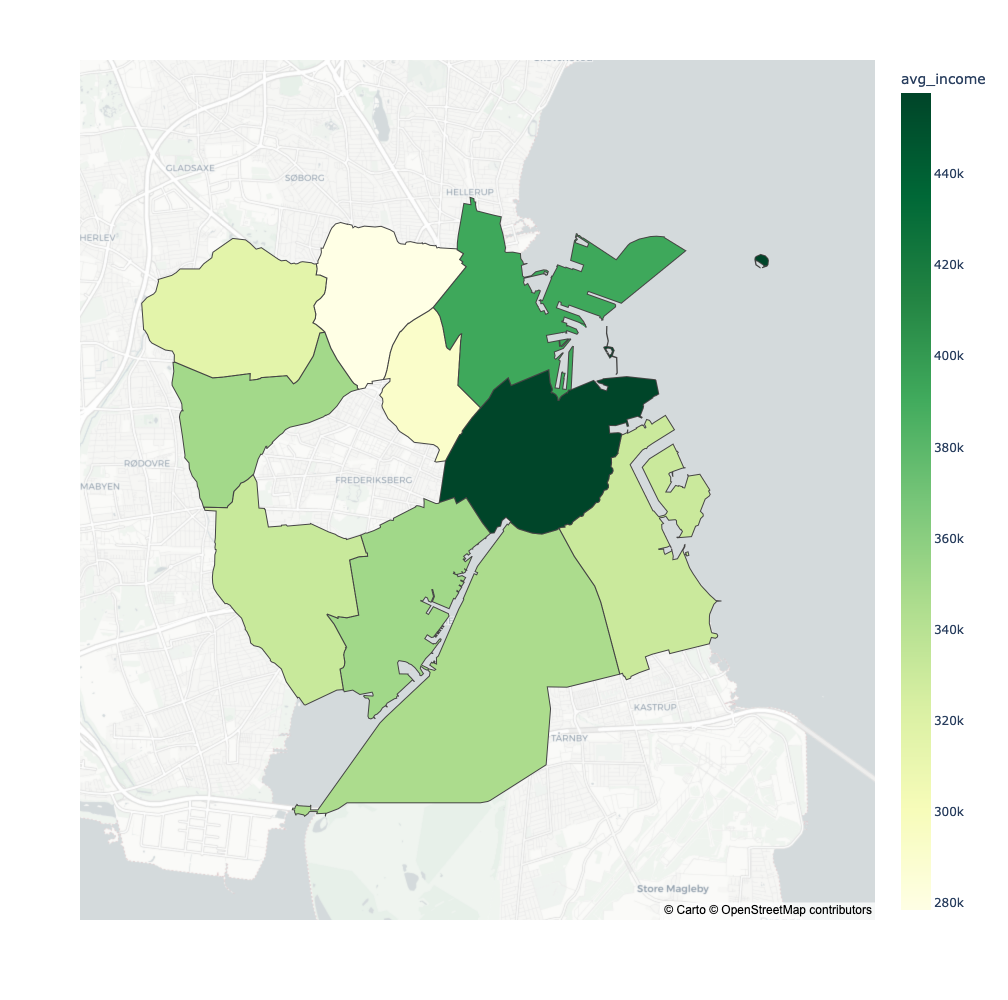

In [75]:

fig = px.choropleth_mapbox(
    df_income_2019,
    locations="id",
    geojson=districts_cph,
    color="avg_income",
    color_continuous_scale="YlGn",
    mapbox_style="carto-positron",
    center={"lat": 55.6760968, "lon": 12.5683371},
    zoom=11,
    width=1000,
    height=1000,
    labels="district"
)

fig.show()

